In [40]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import string
import seaborn as sns
from scipy import stats
import spacy
import matplotlib.pyplot as plt

In [41]:
#Read in dataframe from Spotify Data Extraction section containing musical attributes
spotify_df = pd.read_csv('spotify_genre_df_cleaned3.csv')

Questions:
-What are the most frequent words associated with each genre?
    -Top 10 chart of each genre, word clouds
-Which genres have more overall word counts? What about unique words? How about named entities?
-What are the topics discussed in each genre? (Attempt with LDA article)

-Which genres have the highest of each attribute? (danceability, energy, loudness, speechiness, instrumentalness, liveness, valence, tempo, duration)


-How do each of the quantitative variables correlate to each other? (heatmap)

-What is the distribution of each attribute for each genre? (box plot)
-What is the correlation between each attribute and genre?

-What is the breakdown of songs per genre, artists per genre, albums per genre?
*Add column for # artists and count unique words, count before stop, most frequent word
-(Aggregate data into genre and add variance)
-How many artists per genre?

-BOX PLOT OF DISTRIBUTION OF NUMERIC VARIABLES FOR EACH GENRE
-VARIABLES AGAINST COUNT OF GENRE
-HEATMAP OF CORRELATION BETWEEN NUMERICAL VARIABLES, ANOVA TEST FOR NUM/CAT
-HISTOGRAM OF DISTRUBUTIONS OF NUMERICAL VARIABLES
-PIE CHARTS OR STACKED BAR GRAPHS OF CATEGORICAL VARIABLES DISTRIBUTION

In [81]:
spotify_df_agg

,playlist_name,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
0,Country,0.5715,0.6695,-6.3630,0.0335,0.000001,0.1235,0.519,124.9930,3.531117,211867.0,4.0,274.0,125.0,107.0,65.0,5.0,200.0,1708.0,756.0
1,Electronic/Dance,0.6160,0.8380,-4.8665,0.0594,0.012300,0.1525,0.325,127.9875,3.627825,217669.5,4.0,153.0,69.0,38.0,20.0,0.0,362.0,1747.0,1471.0
2,Hip-Hop,0.7590,0.6230,-6.7195,0.2295,0.000000,0.1350,0.445,121.0750,3.297925,197875.5,4.0,493.0,244.0,175.0,121.0,11.0,220.0,1798.0,752.0
3,Pop,0.6435,0.6240,-6.0205,0.0515,0.000000,0.1180,0.466,118.8915,3.479333,208760.0,4.0,337.0,156.0,102.0,62.0,4.0,437.0,1762.0,1168.0
4,Rock,0.4920,0.7680,-5.8910,0.0412,0.000094,0.1250,0.401,124.0260,3.948950,236937.0,4.0,248.0,115.0,84.0,51.0,2.0,322.0,1793.0,967.0


In [29]:
%%capture

genres = ['Rock', 'Country', 'Hip-Hop', 'Pop', 'Electronic/Dance']
spotify_df['count_artist'] = np.nan
spotify_df['count_track'] = np.nan
spotify_df['count_album'] = np.nan

for genre in genres:
    for i in spotify_df[spotify_df['playlist_name'] == genre].index:  
        spotify_df['count_artist'][i] = spotify_df[spotify_df['playlist_name'] == genre]['artist'].nunique()
        spotify_df['count_track'][i] = spotify_df[spotify_df['playlist_name'] == genre]['track_name'].nunique()
        spotify_df['count_album'][i] = spotify_df[spotify_df['playlist_name'] == genre]['album'].nunique()

In [32]:
spotify_df.columns

Index(['track_name', 'artist', 'album', 'track_id', 'playlist_name',
       'danceability', 'energy', 'full_key', 'key', 'mode', 'loudness',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_minutes', 'duration_ms', 'time_signature', 'lyrics',
       'lyrics_tokenized', 'word_count', 'lyrics_cleaned', 'named_entities',
       'word_count_cleaned', 'word_count_unique', 'word_count_cleaned_unique',
       'entity_count_unique', 'count_artist', 'count_track', 'count_album'],
      dtype='object')

In [75]:
spotify_df.groupby(['playlist_name'], as_index=False).aggregate('mean')

,playlist_name,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
0,Country,0.568432,0.633098,-7.124778,0.041482,0.004473,0.185550,0.529803,124.242878,3.612148,216728.8555,3.9240,267.1760,123.7305,105.2605,65.9540,6.5570,200.0,1708.0,756.0
1,Electronic/Dance,0.609902,0.808250,-5.083547,0.096379,0.210112,0.218809,0.355264,128.585491,3.821456,229287.3735,3.9645,172.4835,84.9365,51.9545,32.6735,3.8260,362.0,1747.0,1471.0
2,Hip-Hop,0.738308,0.624119,-6.901738,0.229157,0.005786,0.207348,0.459637,120.699137,3.467361,208041.6530,3.9840,436.9815,221.1660,159.8355,113.1015,13.2165,220.0,1798.0,752.0
3,Pop,0.631118,0.612103,-6.465645,0.080024,0.012772,0.168975,0.484786,120.708340,3.544961,212697.6750,3.9320,331.3630,165.9530,105.0340,69.2630,8.8695,437.0,1762.0,1168.0
4,Rock,0.482873,0.731268,-6.464162,0.056185,0.088063,0.194278,0.429403,124.554217,4.196194,251771.6145,3.9345,252.0780,121.0225,85.8175,53.6730,4.6610,322.0,1793.0,967.0


In [77]:
spotify_df_agg = spotify_df.groupby(['playlist_name'], as_index=False).aggregate('median')

In [46]:
numerical_variables = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 
                       'valence', 'tempo', 'duration_minutes', 'word_count', 'word_count_cleaned', 'word_count_unique',
                       'word_count_cleaned_unique', 'entity_count_unique']

fixed_variables = ['count_artist', 'count_track', 'count_album']

categorical_variables = ['playlist_name', 'full_key', 'key', 'mode', 'lyrics', 'lyrics_tokenized', 
                         'lyrics_cleaned', 'named_entities']

target_variable = 'playlist_name'

In [39]:
spotify_df[numerical_variables].head(5)

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,count_artist,count_track,count_album
0,0.556,0.913,-2.360,0.0437,0.000009,0.346,0.730,96.184,4.702667,306.0,161.0,144.0,105.0,322.0,1793.0,967.0
1,0.592,0.767,-2.788,0.0270,0.001650,0.127,0.328,96.483,5.495550,286.0,154.0,151.0,98.0,322.0,1793.0,967.0
2,0.433,0.959,-4.040,0.0431,0.000000,0.028,0.365,172.984,4.489550,461.0,174.0,106.0,66.0,322.0,1793.0,967.0
3,0.502,0.912,-4.556,0.0564,0.000173,0.106,0.720,116.761,5.032000,249.0,138.0,85.0,48.0,322.0,1793.0,967.0
4,0.595,0.717,-4.803,0.0295,0.002740,0.108,0.547,88.969,3.598450,248.0,115.0,79.0,49.0,322.0,1793.0,967.0


In [45]:
spotify_df[categorical_variables].head(5)

,playlist_name,full_key,key,mode,lyrics,lyrics_tokenized,lyrics_cleaned,named_entities
0,Rock,C Major,C,Major,gettin' born in the state of mississippi po...,"['gettin', ""'"", 'born', 'in', 'the', 'state', ...","['gettin', 'born', 'state', 'mississippi', 'po...","[mississippi poppa, alabama, sweet louisiana r..."
1,Rock,A Minor,A,Minor,psychic spies from china try to steal your mi...,"['psychic', 'spies', 'from', 'china', 'try', '...","['psychic', 'spy', 'china', 'try', 'steal', 'e...","(china, sweden, east, hollywood, hollywood, al..."
2,Rock,A Major,A,Major,keep you in the dark you know they all preten...,"['keep', 'you', 'in', 'the', 'dark', 'you', 'k...","['keep', 'dark', 'know', 'pretend', 'keep', 'd...",()
3,Rock,C# Major,C#,Major,load up on guns bring your friends it's fun t...,"['load', 'up', 'on', 'guns', 'bring', 'your', ...","['load', 'gun', 'bring', 'friend', 'fun', 'los...",()
4,Rock,C Major,C,Major,scar tissue that i wish you saw sarcastic mis...,"['scar', 'tissue', 'that', 'i', 'wish', 'you',...","['scar', 'tissue', 'wish', 'saw', 'sarcastic',...","(kentucky, fallin, ma, pa, viewin, autumn)"


In [ ]:
genres = ['Rock', 'Pop', 'Hip-Hop', 'Country', 'Electronic/Dance']

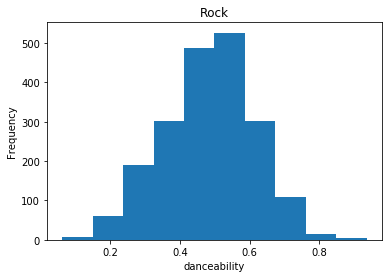

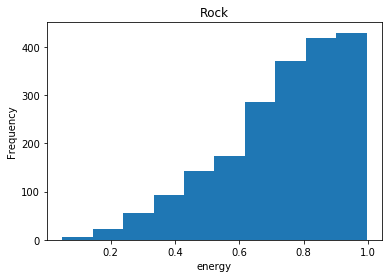

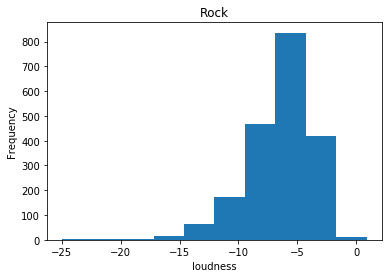

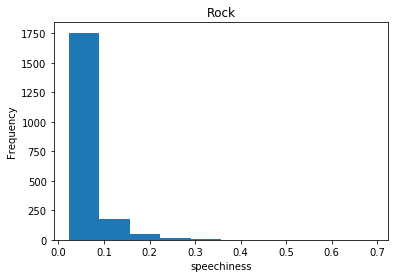

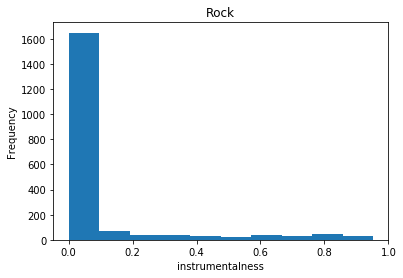

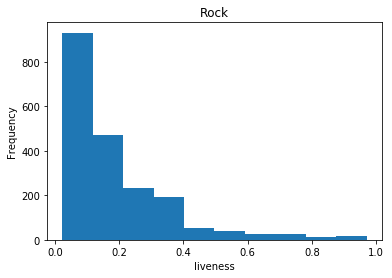

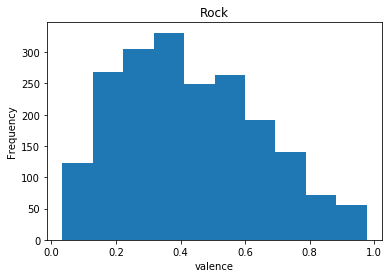

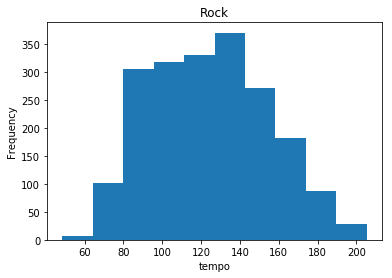

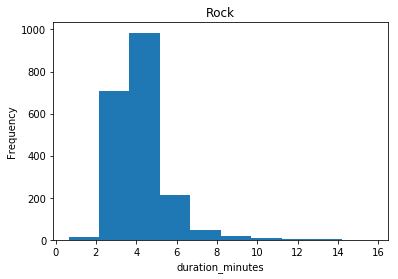

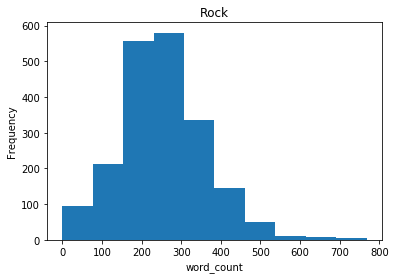

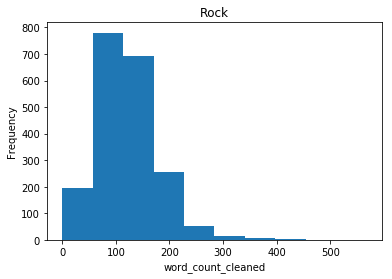

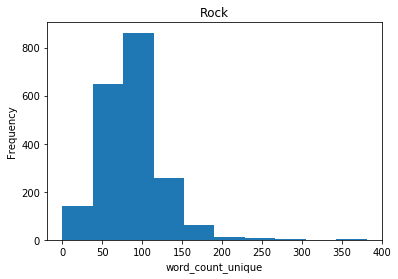

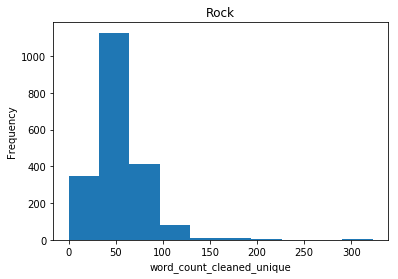

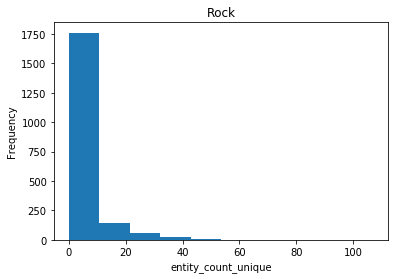

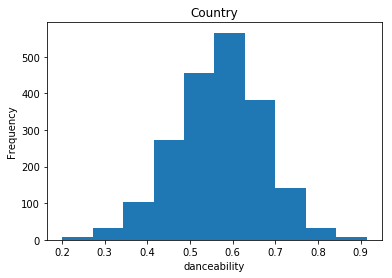

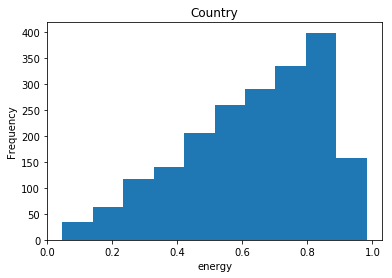

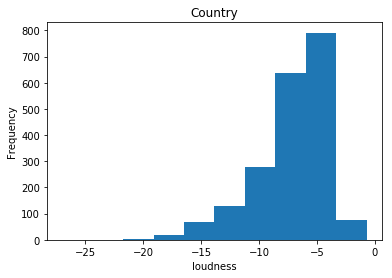

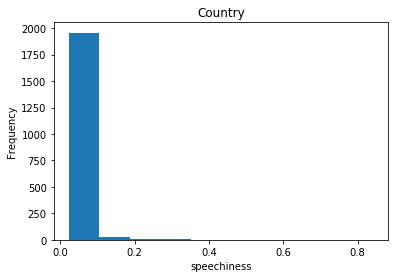

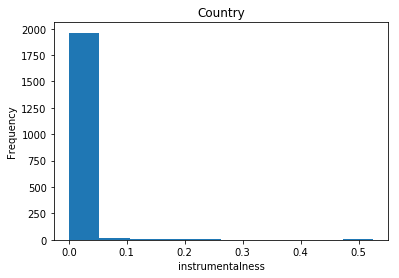

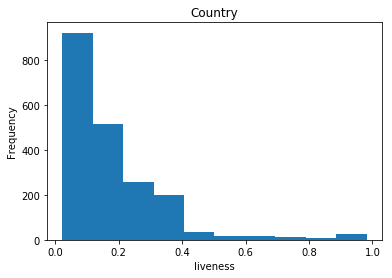

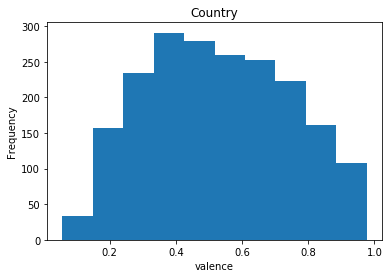

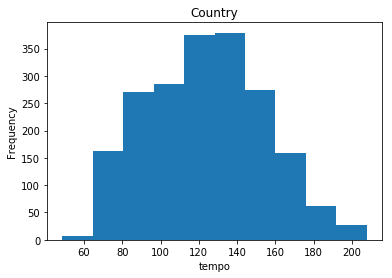

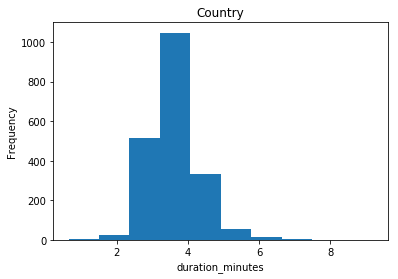

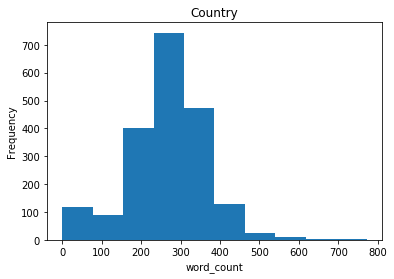

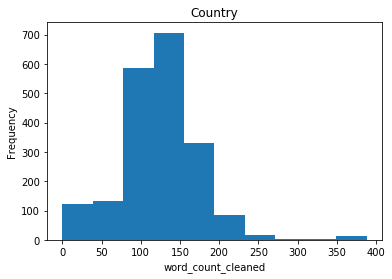

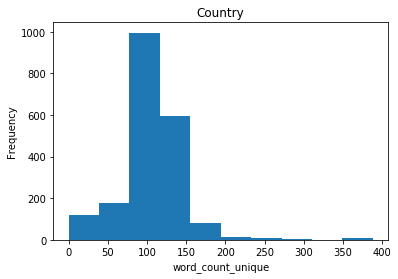

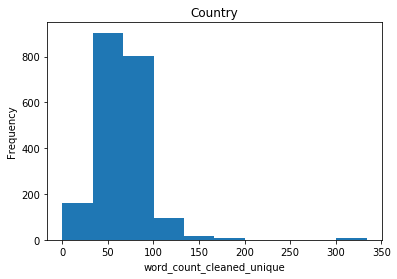

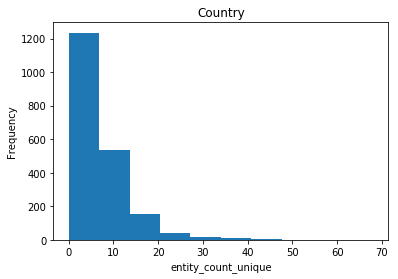

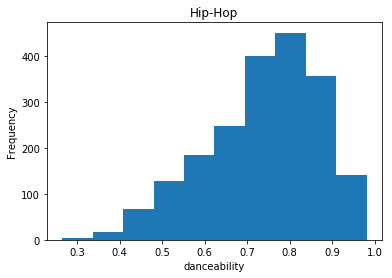

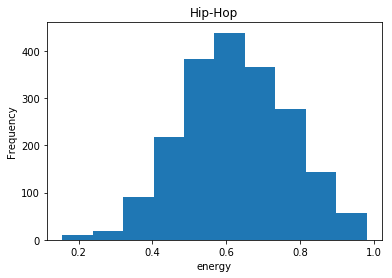

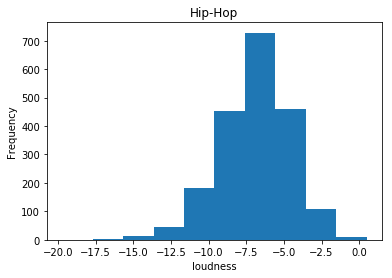

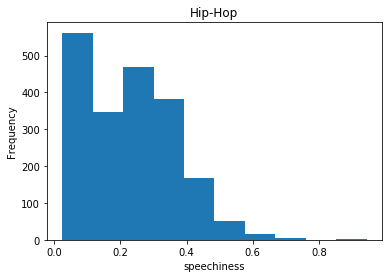

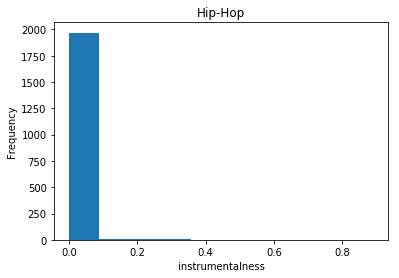

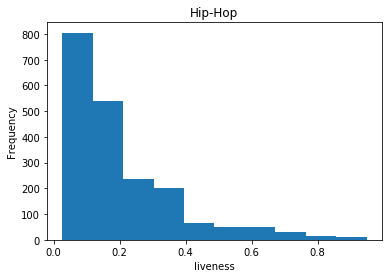

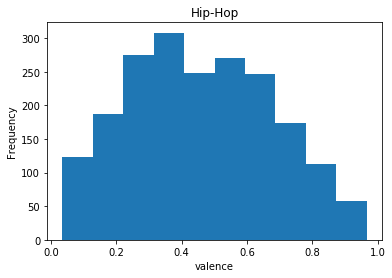

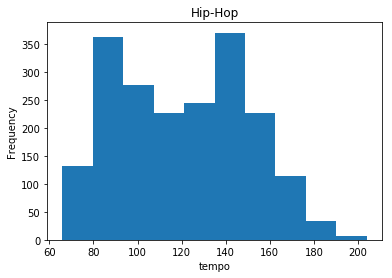

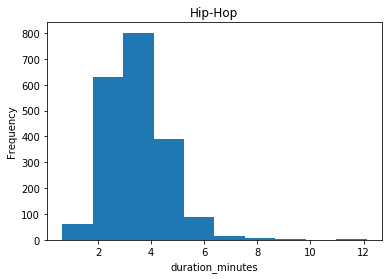

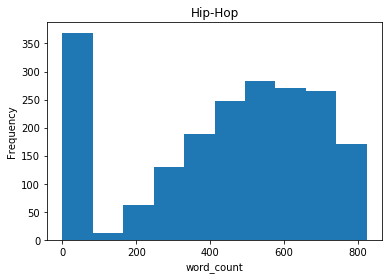

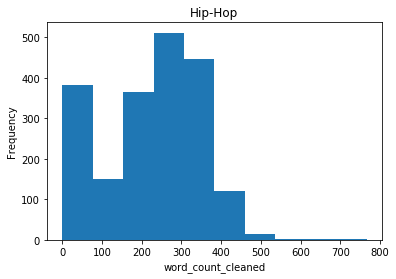

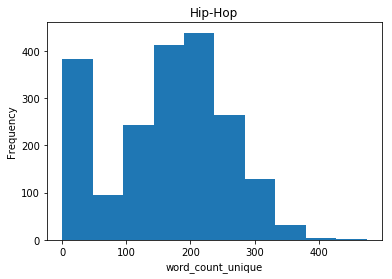

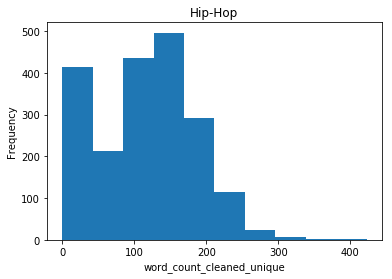

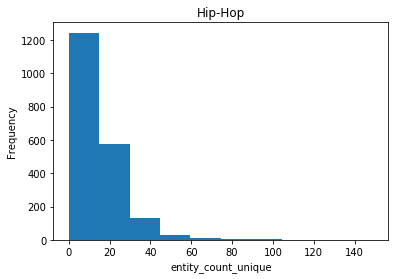

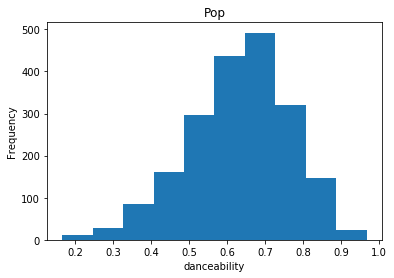

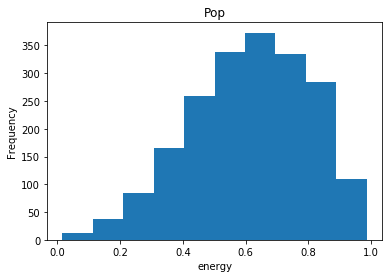

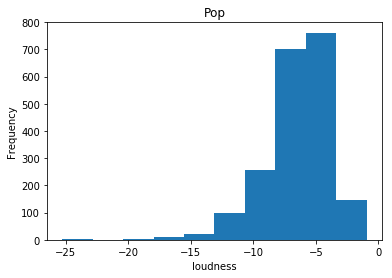

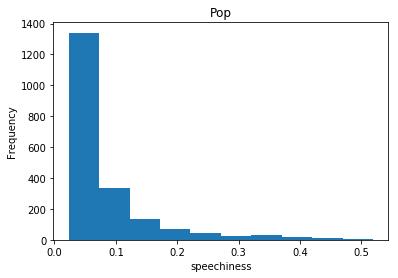

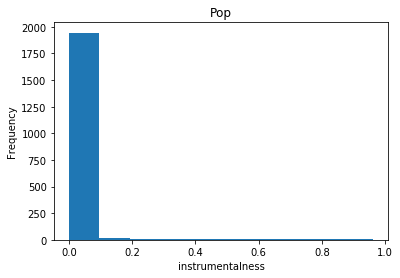

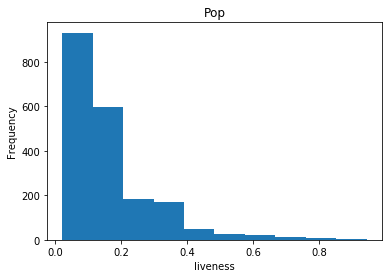

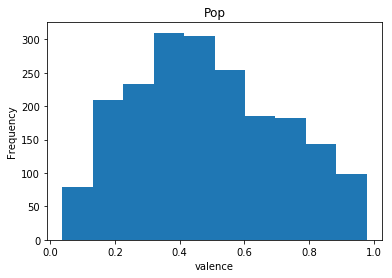

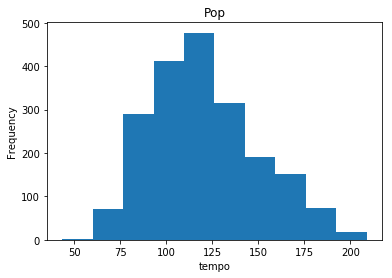

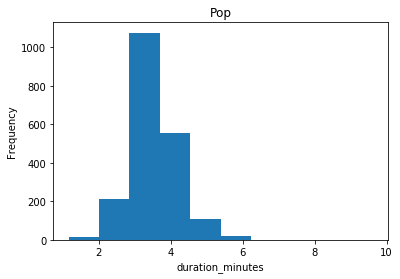

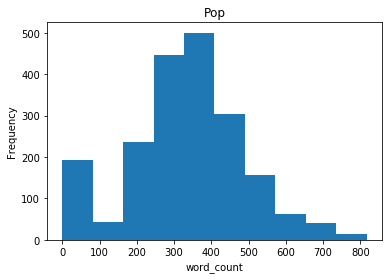

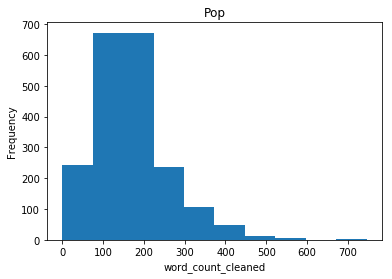

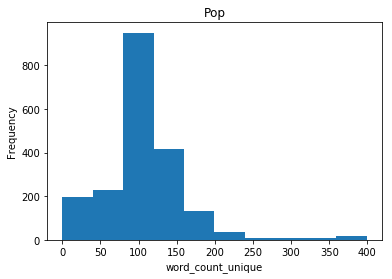

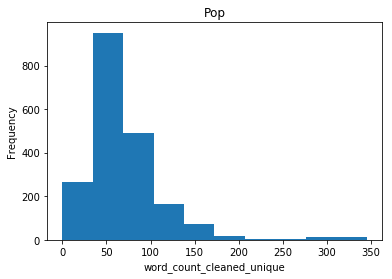

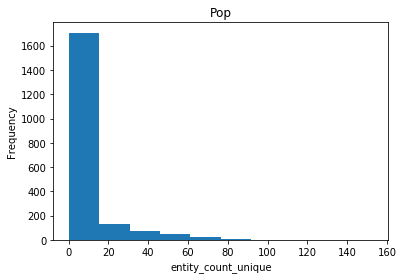

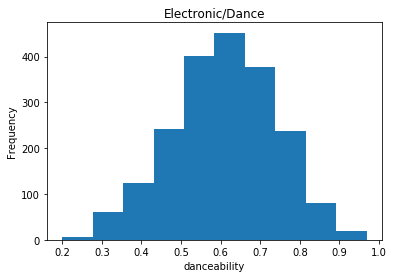

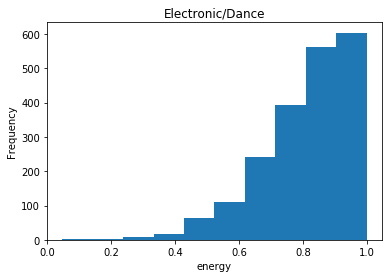

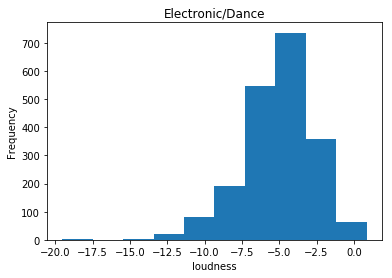

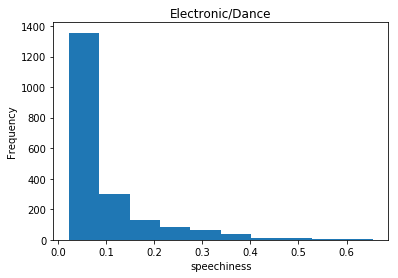

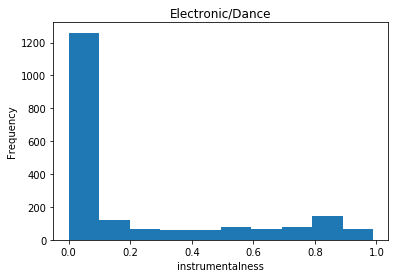

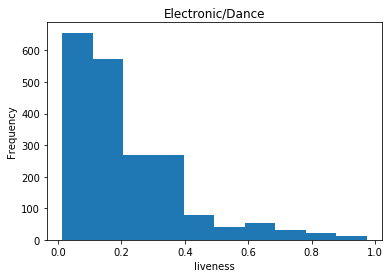

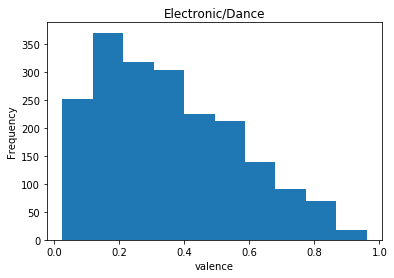

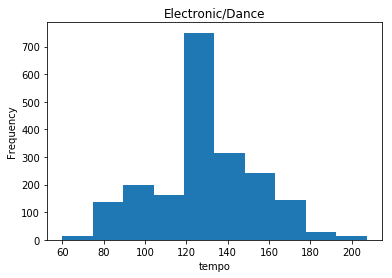

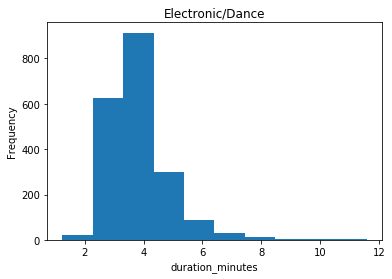

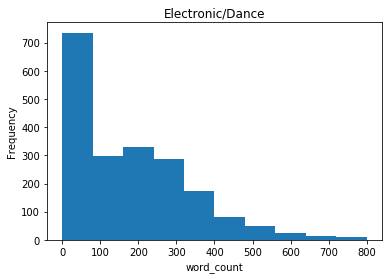

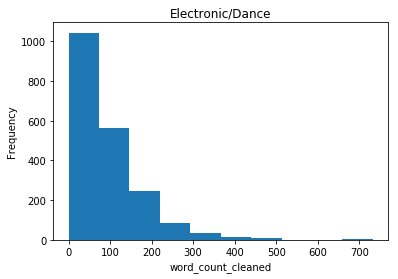

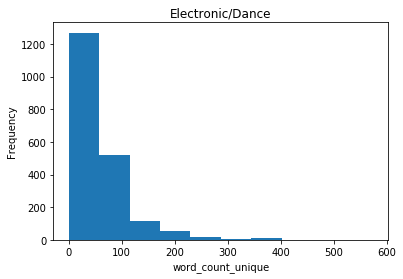

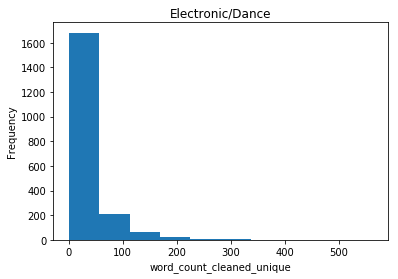

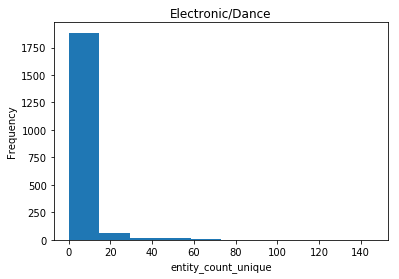

In [62]:
for genre in genres:
    for feature in numerical_variables:
        spotify_df[spotify_df['playlist_name'] == genre][feature].plot.hist()    
        plt.xlabel(feature)
        plt.title(genre)
        plt.show()
        

        

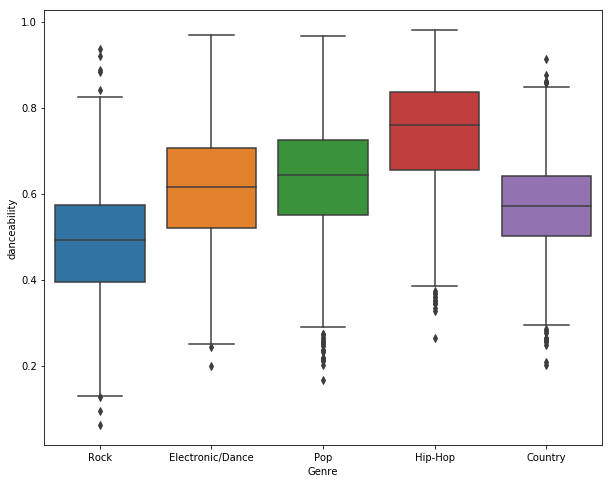

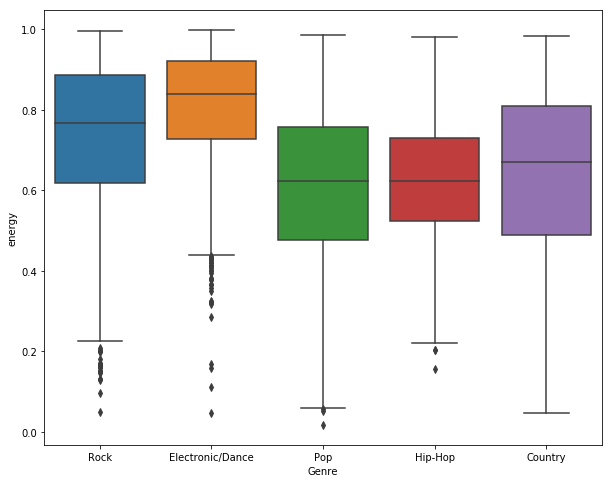

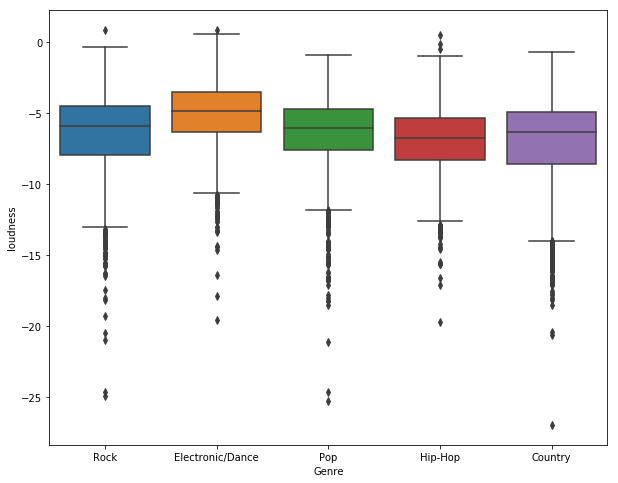

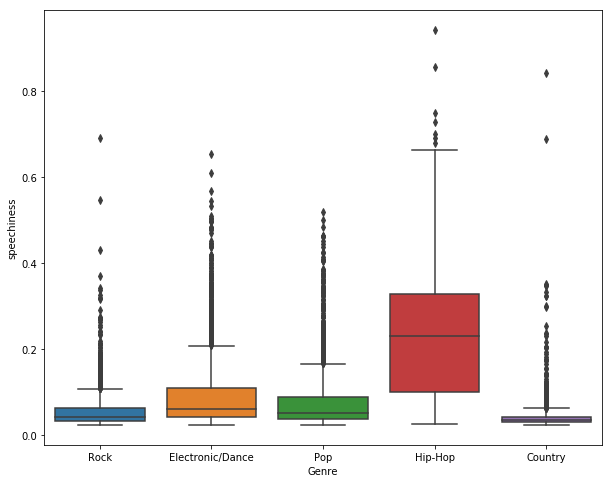

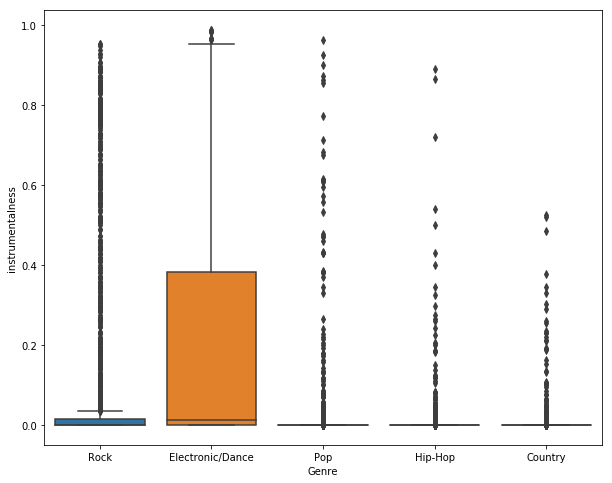

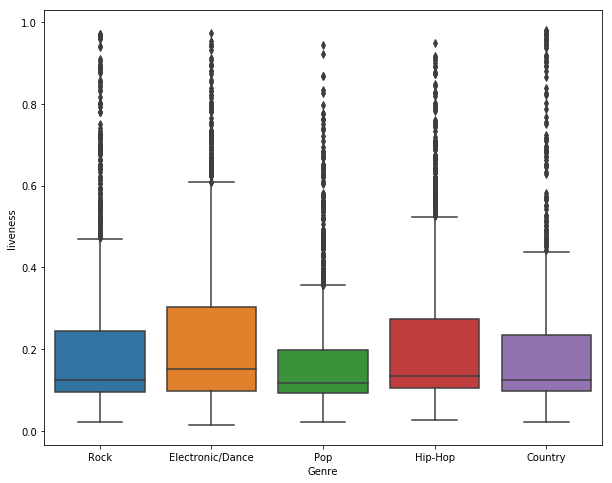

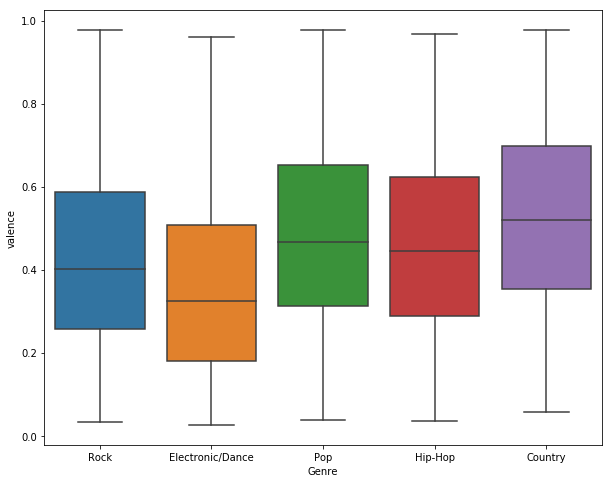

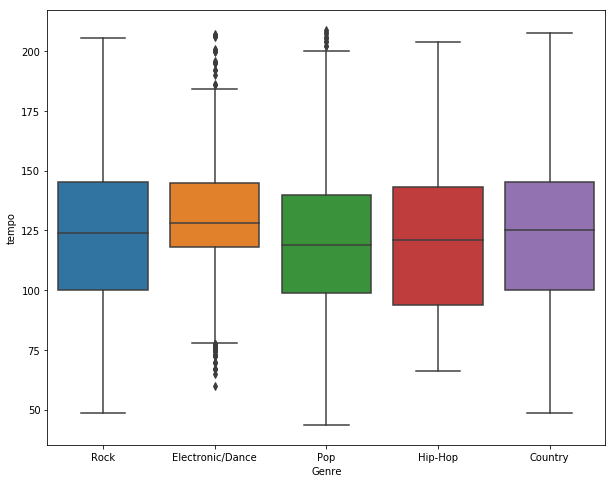

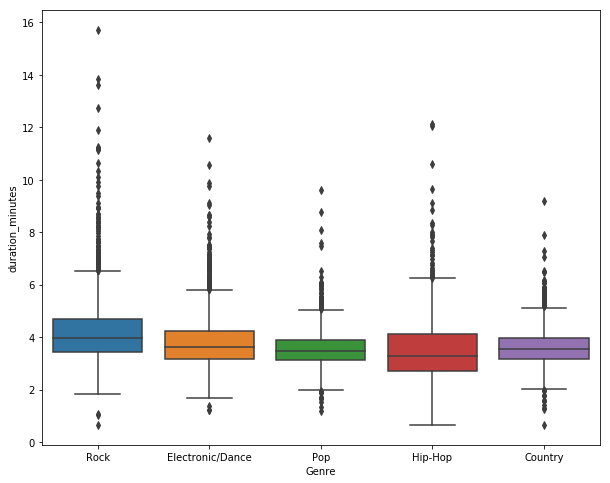

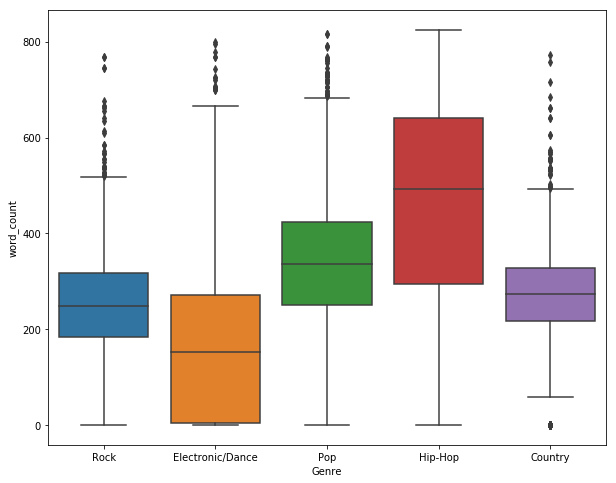

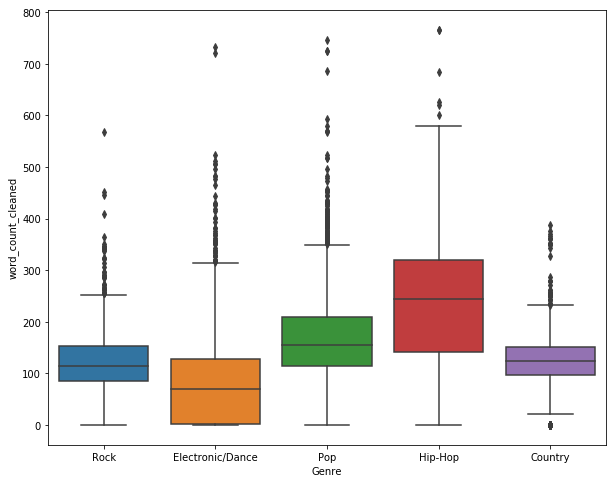

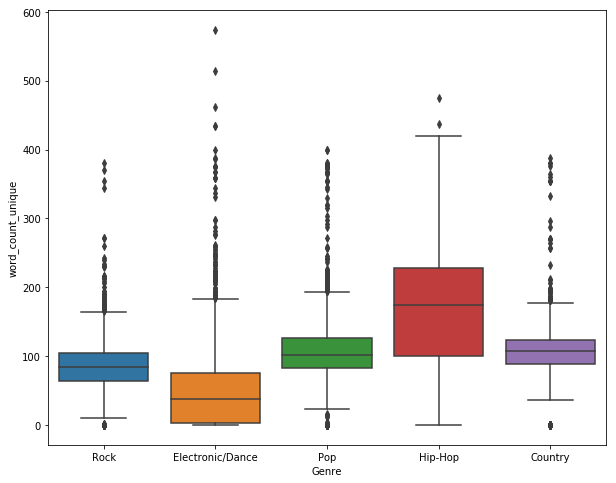

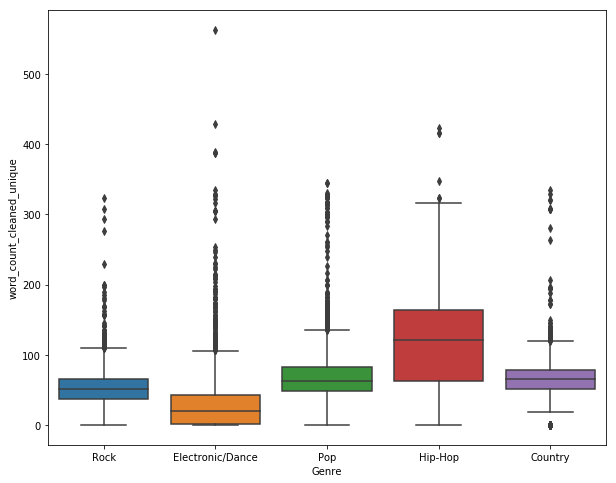

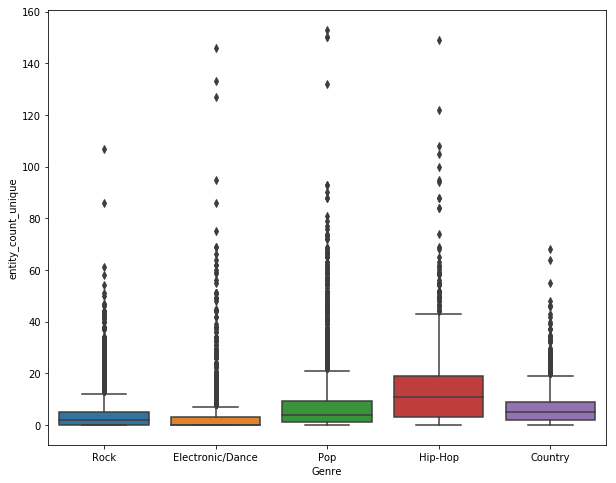

In [73]:
for feature in numerical_variables:
    sns.boxplot(data=spotify_df, x='playlist_name', y=feature)
    #sns.swarmplot(data=spotify_df.head(2001), x='playlist_name', y=feature, size=10)
    plt.xlabel('Genre')
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()    

#spotify_df[spotify_df['playlist_name'] == 'Rock']['word_count'].plot.hist()
#plt.show()

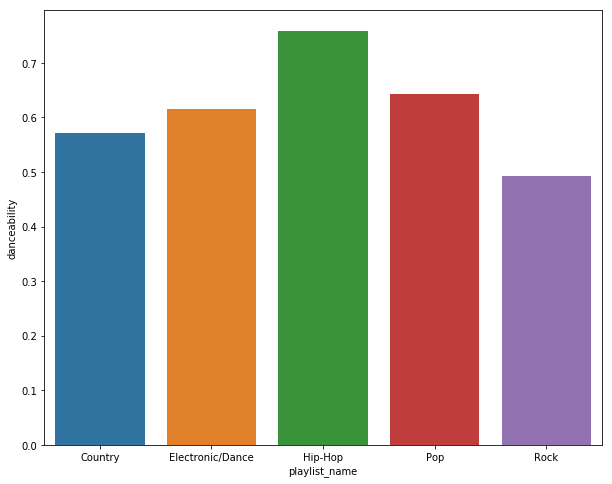

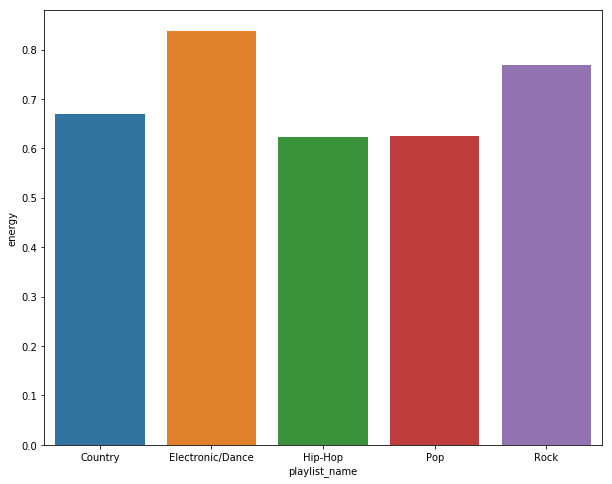

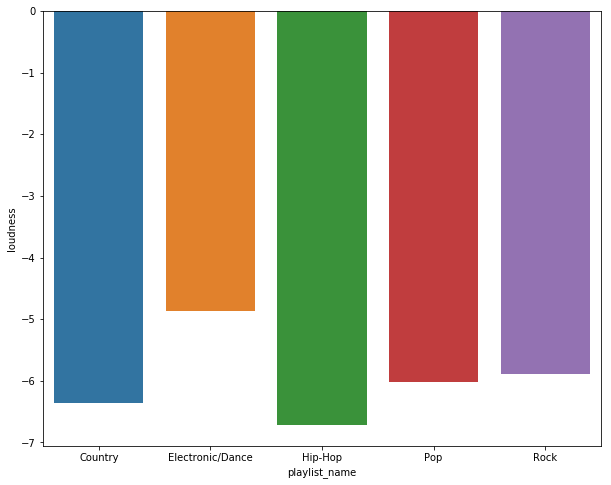

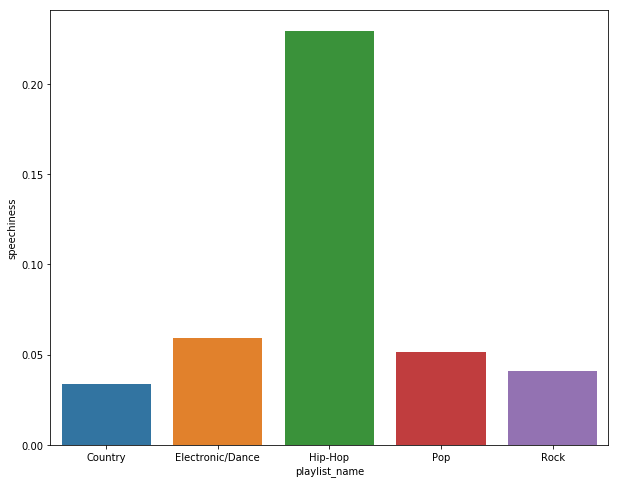

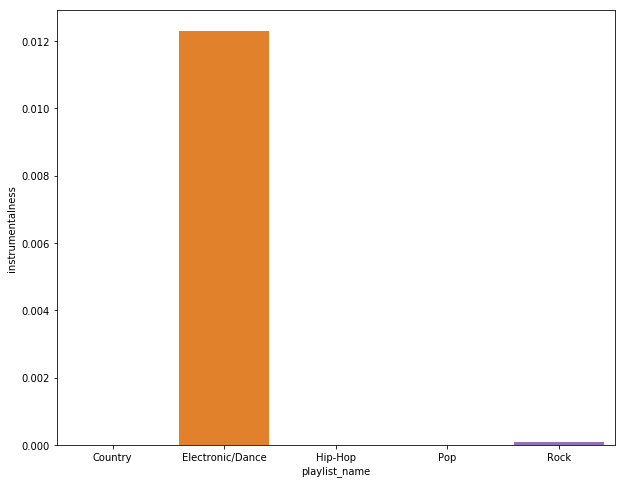

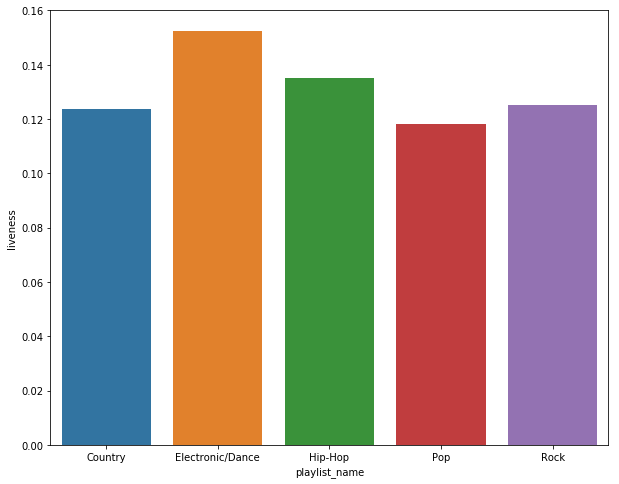

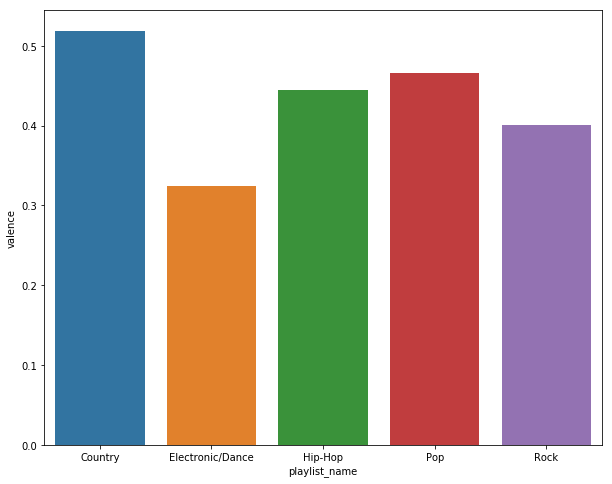

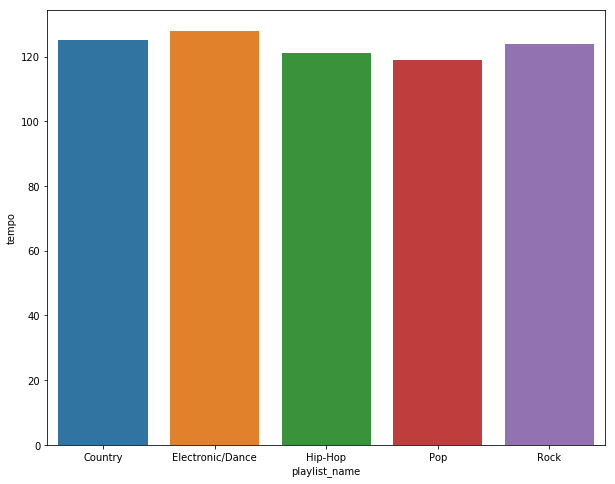

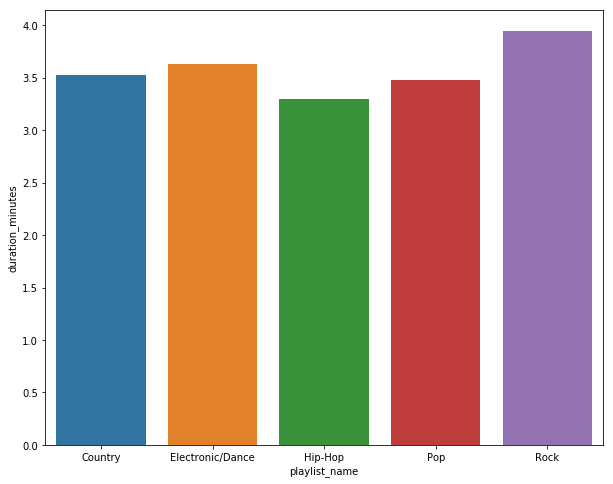

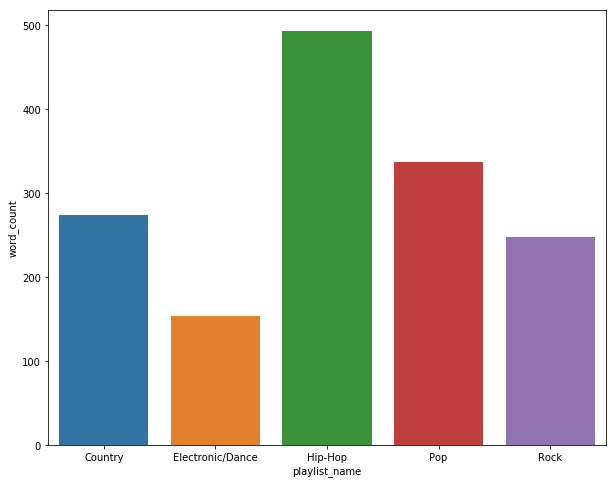

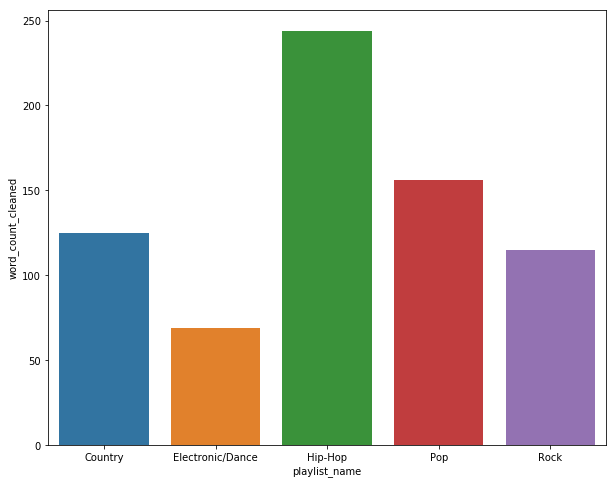

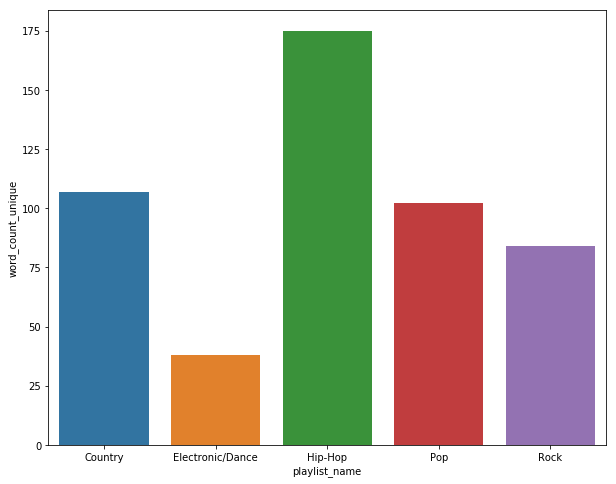

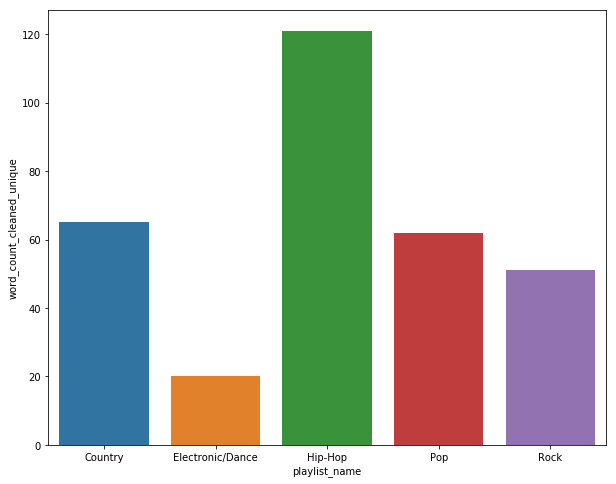

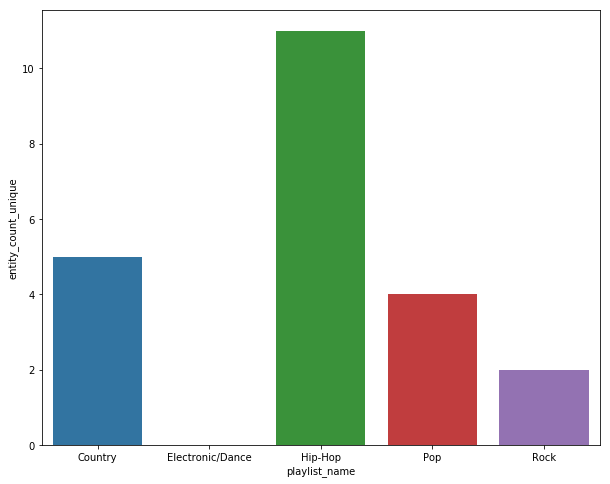

In [79]:
for feature in numerical_variables:
    sns.barplot(data=spotify_df_agg, x='playlist_name', y=feature)
    plt.show()

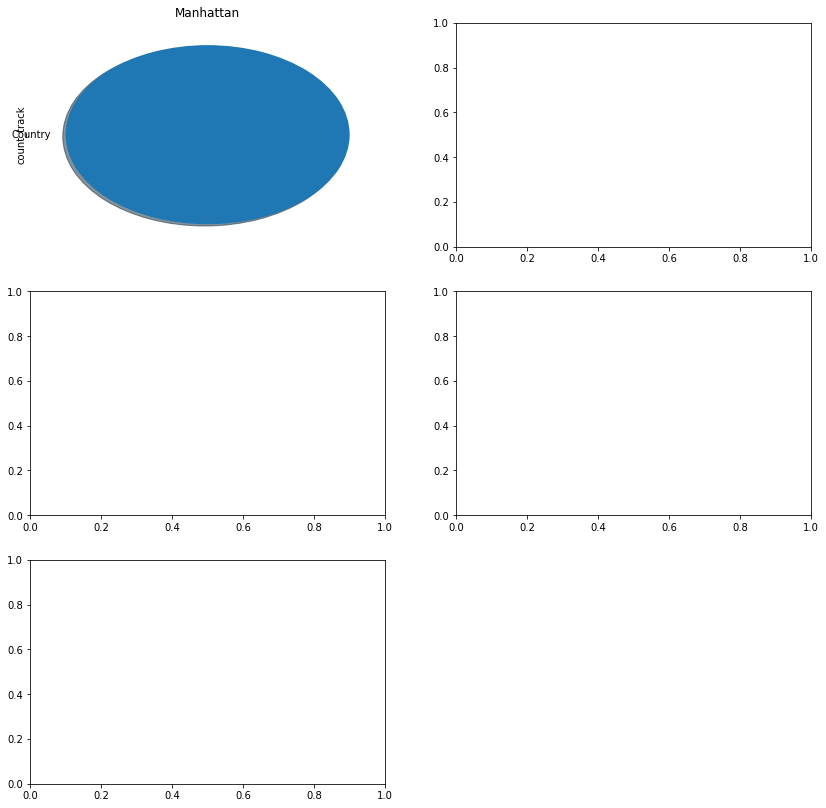

In [84]:
#Plot pie charts of Race across borough
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.delaxes(axes[2,1])

spotify_df_agg[spotify_df_agg['playlist_name'] == 'Rock'].plot(ax=axes[0,0], kind='pie', \
                                labels=spotify_df_agg['playlist_name'], y='count_track', \
                                figsize=[14, 14], title='Manhattan', legend=False, shadow=True)
#race_df[race_df['playlist_name'] == 'Queens'].plot(ax=axes[0,1], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Queens', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Brooklyn'].plot(ax=axes[1,0], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Brooklyn', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Staten Island'].plot(ax=axes[1,1], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Staten Island', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Bronx'].plot(ax=axes[2,0], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Bronx', legend=False, shadow=True)
plt.show()

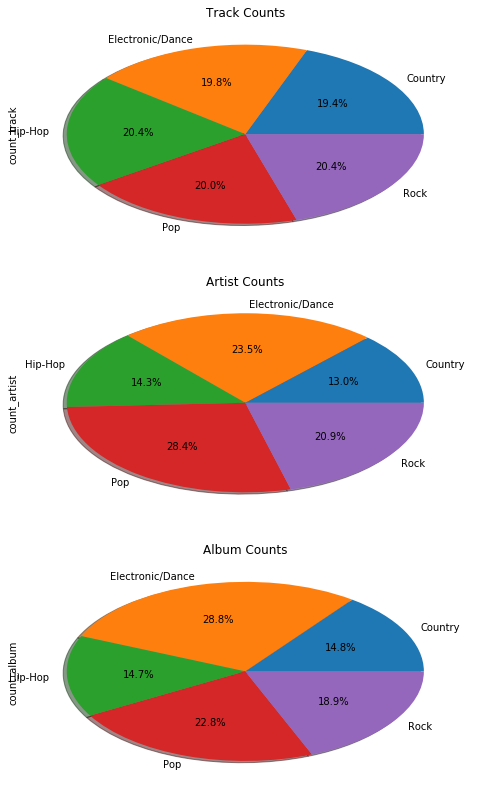

In [109]:
#Plot pie charts of Race across borough
fig, axes = plt.subplots(nrows=3, ncols=1)
#fig.delaxes(axes[3,1])

spotify_df_agg.plot(ax=axes[0], kind='pie', y='count_track', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Track Counts', legend=False, shadow=True, )

spotify_df_agg.plot(ax=axes[1], kind='pie', y='count_artist', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Artist Counts', legend=False, shadow=True)

spotify_df_agg.plot(ax=axes[2], kind='pie', y='count_album', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Album Counts', legend=False, shadow=True)

plt.show()

In [120]:
type(spotify_df['playlist_name'][0]), type(spotify_df['danceability'][0])

(str, numpy.float64)

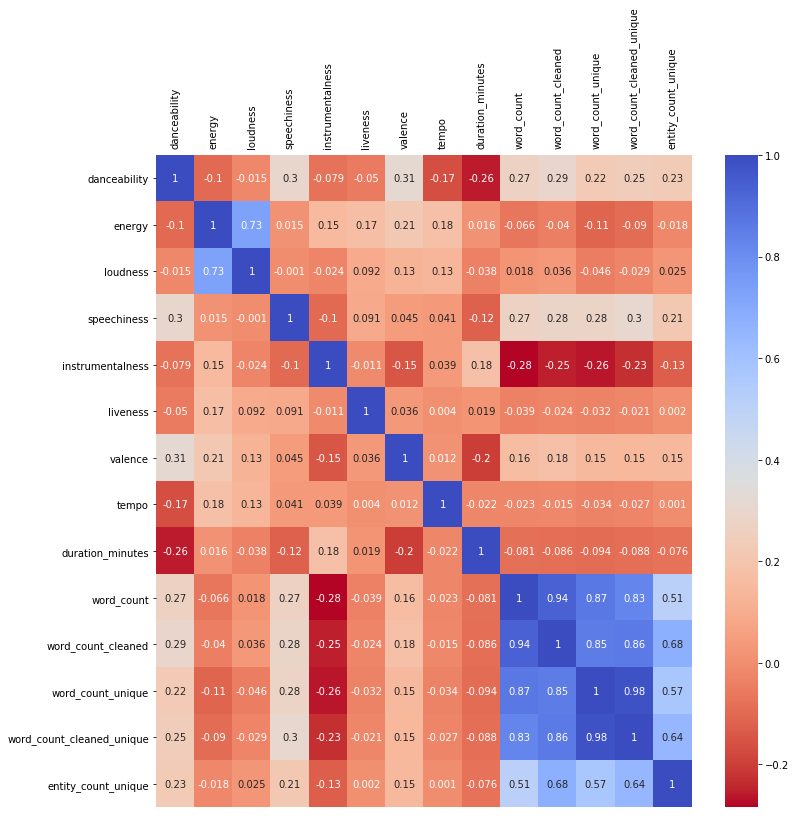

In [126]:
#Correlation Matrix including Y-variables (rates) 
corr = spotify_df[numerical_variables].corr().round(3)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.tick_params(labeltop=True, labelbottom=False, bottom=False)
plt.xticks(rotation=90)
plt.show()

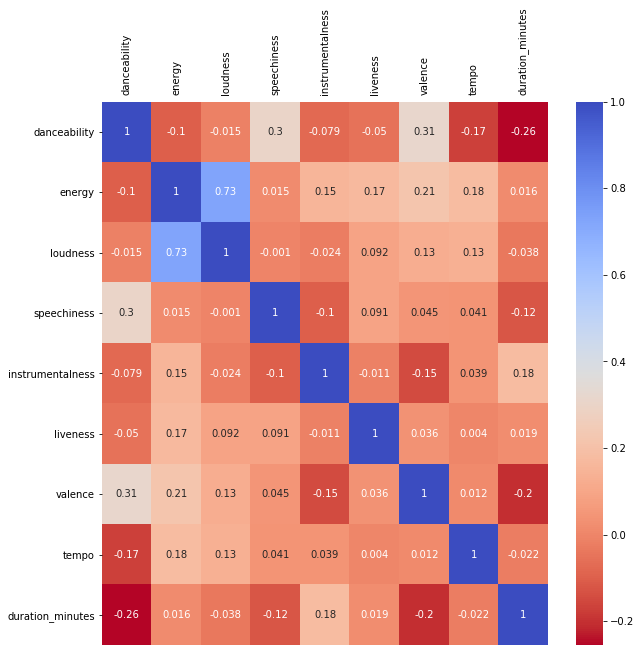

In [130]:
#Correlation Matrix including Y-variables (rates) 
corr = spotify_df[numerical_variables[:9]].corr().round(3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.tick_params(labeltop=True, labelbottom=False, bottom=False)
plt.xticks(rotation=90)
plt.show()